# Linear PV Estimator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from oedisi.componentframework import wiring_diagram_utils
from post_process import plotter

ROOT = os.getcwd()
OUTPUTS = f"{ROOT}/outputs"
SCENARIO_DIR, SCENARIOS, _ = next(os.walk(f'{ROOT}/scenario/'))

print(SCENARIO_DIR)
for idx, scenario in enumerate(SCENARIOS):
    print(idx, scenario)

/home/tylor/dev/oedisi_dopf/scenario/
0 omoo_medium_extreme
1 small_extreme
2 medium_extreme
3 ieee123_update
4 omoo_small
5 small
6 omoo_medium
7 ekf_ieee123
8 omoo
9 epri_j1
10 medium_medium
11 large
12 medium_high
13 ieee123
14 medium_low
15 small_medium
16 small_low
17 lest_small
18 medium
19 small_high
20 lest_ieee123
21 lest_test


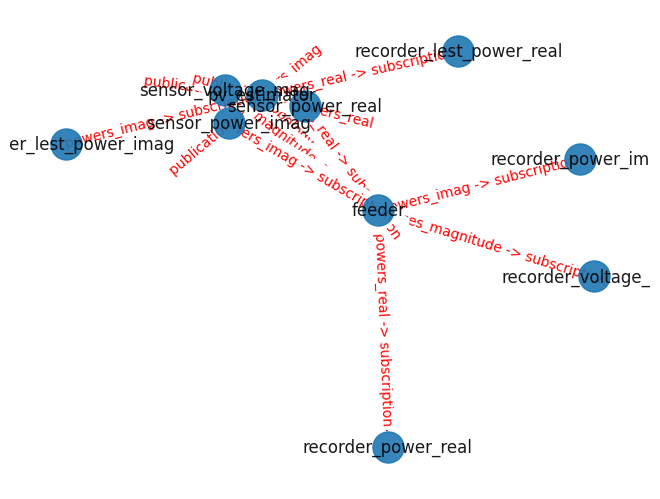

In [3]:
index = 20
SCENARIO = SCENARIOS[index]

path = f"{SCENARIO_DIR}{SCENARIO}"
with open(f"{path}/system.json") as f:
    wiring_diagram = wiring_diagram_utils.WiringDiagram.parse_obj(json.load(f))

wiring_diagram_utils.plot_graph_matplotlib(wiring_diagram)

In [3]:
os.system(f"oedisi build --system {path}/system.json --component-dict {path}/components.json --target-directory build_{SCENARIO}") 

Loading the components defined in /home/tylor/dev/oedisi_dopf/scenario/lest_ieee123/components.json
Loading system json /home/tylor/dev/oedisi_dopf/scenario/lest_ieee123/system.json
Building system in build_lest_ieee123


0

In [4]:
os.system("pkill -9 helics_broker")
os.system(f"oedisi run --runner build_{SCENARIO}/system_runner.json")

[warn] helics-cli's web interface is not installed. You may want to run `pip install "helics[cli]"`.
[warn] helics-cli's observer functionality is not installed. You may want to run `pip install "helics[cli]"`.
[info] Running federation: lest_ieee123
[info] Running federate recorder_power_real as a background process
[info] Running federate recorder_power_imag as a background process
[info] Running federate recorder_voltage_mag as a background process
[info] Running federate recorder_lest_power_real as a background process
[info] Running federate recorder_lest_power_imag as a background process
[info] Running federate feeder as a background process
[info] Running federate sensor_voltage_mag as a background process
[info] Running federate sensor_power_real as a background process
[info] Running federate sensor_power_imag as a background process
[info] Running federate pv_estimator as a background process
[info] Running federate broker as a background process
[info] Waiting for 11 proces

0

In [4]:
# Directory location
directory = f"{OUTPUTS}/{SCENARIO}"
power_real = os.path.join(directory, "power_real.feather")
power_imag = os.path.join(directory, "power_imag.feather")
power_real_est = os.path.join(directory, "lest_power_real.feather")
power_imag_est = os.path.join(directory, "lest_power_imag.feather")
time = ["12:00"]

from math import sqrt, floor
import pandas as pd
from datetime import datetime
import pyarrow.feather as feather
from matplotlib import colormaps

In [9]:
def get_time(x):
    return datetime.strptime(
        x, '%Y-%m-%d %H:%M:%S'
        ).time().strftime("%H:%M")
    
def plot_ang(true, estimated, time, unit="rad"):
    n_nodes = len(true.columns)
    x_axis = np.arange(n_nodes)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x_axis, np.angle(true.to_numpy()[0]), "-o")
    ax.plot(x_axis, np.angle(estimated.to_numpy()[0]), "-o")

    # ax.set_xticks(x_axis, true_voltages.index, rotation=-90, fontsize=5)
    # ax.set_tick_params(axis='x', labelsize=5, rotation=-90)
    ax.set_xlabel("Node number")
    ax.set_ylabel("Voltage Angles")
    ax.legend(["True", "Estimate"])
    ax.set_title(f"Voltage Angles at t={time}")
    return fig

def plot_mag(true, estimated, time, unit="pu"):
    n_nodes = len(true.columns)
    x_axis = np.arange(n_nodes)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x_axis, np.abs(true.to_numpy()[0]), "-o")
    ax.plot(x_axis, np.abs(estimated.to_numpy()[0]), "-o")
    # ax.set_xticks(x_axis, true_voltages.index, rotation=-90, fontsize=5)
    ax.set_xlabel("Node number")
    ax.set_ylabel(f"Voltage Magnitudes ({unit})")
    ax.legend(["True", "Estimate"])
    ax.set_title(f"Voltage Magnitudes at t={time}")
    return fig


def errors(true_voltages, estimated_voltages):
    true_mag = np.abs(true_voltages)
    nonzero_parts = true_mag != 0.0
    MAPE = np.mean(
        np.array(np.abs(true_mag - np.abs(estimated_voltages)) / true_mag)[
            nonzero_parts
        ]
        * 100
    )
    angle_difference = np.abs(np.angle(true_voltages) - np.angle(estimated_voltages))
    angle_difference[angle_difference >= np.pi] = (
        2 * np.pi - angle_difference[angle_difference >= np.pi]
    )
    MAE = np.mean(np.array(angle_difference)[nonzero_parts] * 180 / np.pi)
    return MAPE, MAE


def error_table(true_voltages, estimated_voltages):
    error_table = []
    for i, t in enumerate(true_voltages.columns):
        MAPE, MAE = errors(true_voltages.iloc[:, i], estimated_voltages.iloc[:, i])
        error_table.append({"t": t, "MAPE": MAPE, "MAE": MAE})
    return pd.DataFrame(error_table)


def plot_errors(err_table):
    fig, ax = plt.subplots()
    ax.plot(err_table["t"], err_table["MAPE"])
    ax.plot(err_table["t"], err_table["MAE"])
    ax.legend(["MAPE (magnitudes)", "MAE (angles)"])
    ax.set_ylabel("Error")
    ax.set_xlabel("Time (15 minute)")
    ax.set_title("Voltage Errors")
    ax.set_xticks(err_table["t"][::5], err_table["t"][::5], rotation=-25, fontsize=5)
    return fig

In [15]:
df_act = pd.read_feather(power_real)
df_act['time'] = pd.to_datetime(df_act['time'],format='%Y-%m-%d %H:%M:%S')
df_act.set_index('time', inplace=True)

df_act_a = df_act.filter(like='.1')
df_act_b = df_act.filter(like='.2')
df_act_c = df_act.filter(like='.3')

df_est = pd.read_feather(power_real_est)
df_est['time'] = pd.to_datetime(df_est['time'],format='%Y-%m-%d %H:%M:%S')
df_est.set_index('time', inplace=True)

df_est_a = df_est.filter(like='.1')
df_est_b = df_est.filter(like='.2')
df_est_c = df_est.filter(like='.3')

df_est_a_true = df_est_a.filter(items=df_act_a.columns)
cm = colormaps['tab20'].colors
idx = ['true', 'est']

TypeError: '<' not supported between instances of 'str' and 'int'

In [13]:
time='07:00'
true = df_act.at_time(time)
estimated = ef_est.at_time(time)

err_table = error_table(true, estimated)
plot_errors(err_table).savefig(f"{directory}/errors_morning.png")

TypeError: Index must be DatetimeIndex

<Axes: >

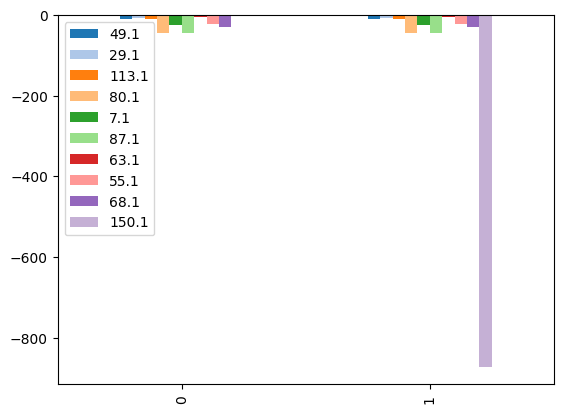

In [6]:
df = pd.concat([df_est_a, df_act_a], ignore_index=True).fillna(0)
fig, ax = plt.subplots()
df.plot.bar(color=cm, ax=ax)

<Axes: >

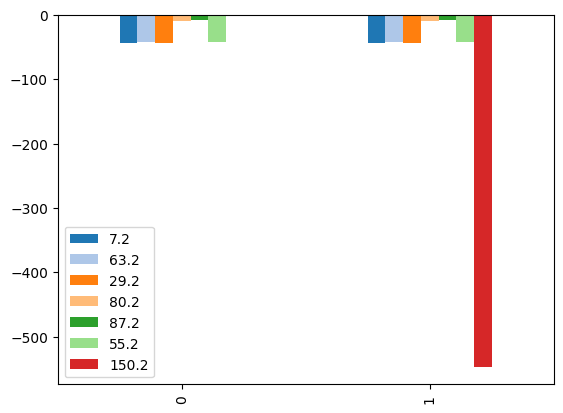

In [7]:
df = pd.concat([df_est_b, df_act_b], ignore_index=True).fillna(0)
fig, ax = plt.subplots()
df.plot.bar(color=cm, ax=ax)

<Axes: >

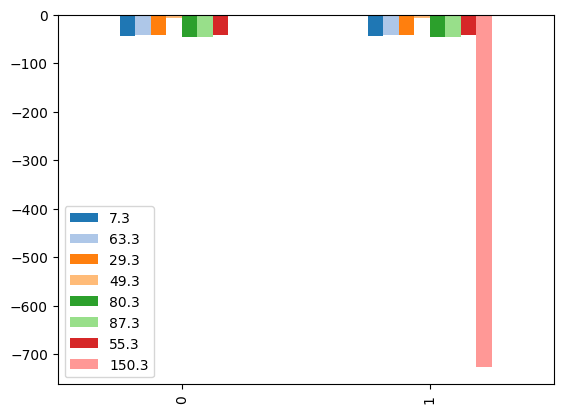

In [8]:
df = pd.concat([df_est_c, df_act_c], ignore_index=True).fillna(0)
fig, ax = plt.subplots()
df.plot.bar(color=cm, ax=ax)